In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from systole.detection import ppg_peaks, interpolate_clipping, ecg_peaks
from systole.plots import plot_rr, plot_evoked, plot_events
from systole import import_dataset1, import_ppg
from systole.utils import heart_rate, to_epochs, input_conversion
from systole.hrv import frequency_domain

from bokeh.io import output_notebook
from bokeh.plotting import show
output_notebook()

sns.set_context('talk')

Loading BokehJS ...

# 5 - Instantaneous and evoked heart rate
In the previous section, we have analyzed the heart rate variability as a property that can be observed in a rather long recording and that might reflect the influence of the sympathetic and/or the parasympathetic nervous system. Such an approach has been widely in psychology to evaluate the trait heart rate variability (HRV) of a given participant on a continuous domain, sometimes in conjunction with experimental manipulations. This approach requires long recording to give a reasonable estimate of the HRV (~5 minutes), and resting conditions are also required to let the nervous system returns to a baseline.

However, psychophysiological interactions can appear at much shorter time scales (as fast as 1-2 seconds after stimulation), and this kind of effect can be approached using evoked heart rate analysis. Evoked heart rate refers to the fluctuation of instantaneous heart rate following stimulation and could be described as the cardiac equivalent of event-related potentials [ERP](https://en.wikipedia.org/wiki/Event-related_potential).

To perform evoked heart rate analysis, we need an ECG recording and a trigger, or stim channel, that will encode the occurrence of the events we want to study. Here, we will use an example dataset included in Systole. The task itself has been described in **[1]**. During the recording, the participant has to rate the emotional valence of 36 neutral and 36 disgusting images (10 seconds max per image). The stim channel encodes the presentation of disgusting (`2`) and neutral (`1`) images.

In [2]:
# Import ECG recording and Stim channel
ecg_df = import_dataset1(modalities=['ECG', 'Stim'])

## Instantaneous heart rate

In [3]:
# Peak detection in the ECG signal using the Pan-Tompkins method
signal, peaks = ecg_peaks(ecg_df.ecg, method='pan-tompkins', sfreq=1000)

Because the heartbeats are discrete events interleaved by unequal intervals, the instantaneous heart rate time series is the results of the interpolation of the individual heart rate estimates.

By defaults, the `plot_rr` function will linearly connect the dots to save memory.

In [4]:
show(
    plot_rr(peaks, input_type='peaks', backend='bokeh', figsize=250)
)

The `heart_rate` function provide more option and allows to select between different interpolation parameter following the ones povided by the `scipy.interpolate.interpolate1d` function.

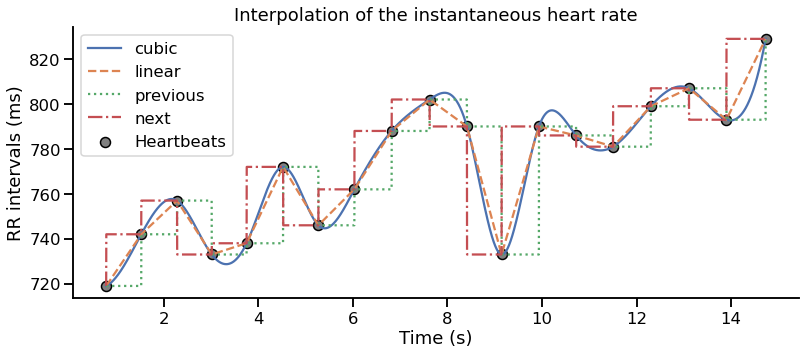

In [5]:
# Select a subsample of the recording
this_peaks = peaks[20000:35000]

_, ax = plt.subplots(figsize=(13, 5))
for kind, color, style in zip(["cubic", "linear", "previous", "next"], 
                               sns.color_palette("deep", n_colors=4),
                               ["-", "--", ":", "-."]):
    hr, time = heart_rate(x=this_peaks, input_type='peaks', kind=kind)
    ax.plot(time, hr, color=color, label=kind, linestyle=style)

# Show individual heartbeats
ax.scatter(np.where(this_peaks)[0][1:]/1000,
           np.diff(np.where(this_peaks)[0]),
           s=100, color="gray", edgecolors="k", label="Heartbeats")
plt.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("RR intervals (ms)")
ax.set_title("Interpolation of the instantaneous heart rate")
sns.despine()

Note that here the timing of the peaks detection matters. The artefact correction, if it is used, should take this into account and never interpolate RR times series directly but always try to infer the presence, or absence, of cardiac cycles. 

## Evoked heart rate

Finding R peaks and extract instantaneous heart rate.

In [6]:
heartrate, new_time = heart_rate(peaks, kind='previous', unit='bpm')

Create stim vectors for neutral and discusting images separately. Here, 1 encode the presentation of an image.

In [7]:
triggers_idx = [
    np.where(ecg_df.stim.to_numpy() == 2)[0], 
    np.where(ecg_df.stim.to_numpy() == 1)[0]
]

In [8]:
neutral, disgust = np.zeros(len(new_time)), np.zeros(len(new_time))

disgust[np.round(np.where(ecg_df.stim.to_numpy() == 2)[0]).astype(int)] = 1
neutral[np.round(np.where(ecg_df.stim.to_numpy() == 1)[0]).astype(int)] = 1

### Event plot

The `plot_events` function can be usefull to visualize the distribution of events during the task.

<AxesSubplot:xlabel='Time'>

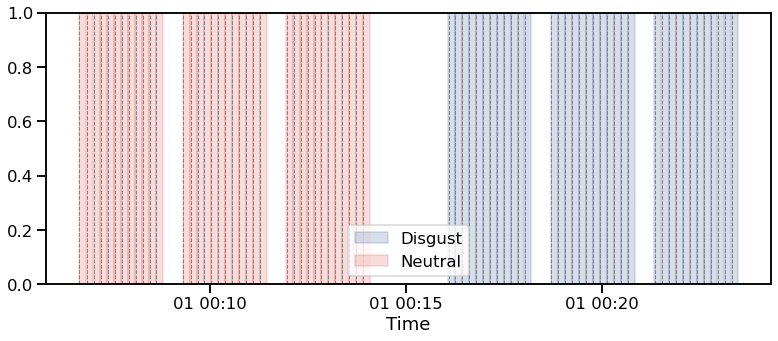

In [9]:
plot_events(triggers_idx=triggers_idx, backend="matplotlib", events_labels=["Disgust", "Neutral"],
            tmin=-0.5, tmax=10.0, palette=[sns.xkcd_rgb["denim blue"], sns.xkcd_rgb["pale red"]],
            figsize=(13, 3))

This plot can be combined with other functionnalities of Systole, for example to wisualize the evolution of instantaneous heart rate across the different trials. 

In [10]:
# First, we create a RR interval plot
rr_plot = plot_rr(peaks, input_type='peaks', backend='bokeh', figsize=250)

show(    
    # Then we add events annotations to this plot using the plot_events function
    plot_events(triggers_idx=triggers_idx, backend="bokeh", events_labels=["Disgust", "Neutral"],
                tmin=-0.5, tmax=10.0, palette=[sns.xkcd_rgb["denim blue"], sns.xkcd_rgb["pale red"]],
                ax=rr_plot.children[0])
)

However, it is still difficult to see if a general tendency emmerges from the time course of the heart rate following the stimulations, and if the two conditions differt from each other. 

### Evoked plot

Systole provide a function `to_epochs` that can easily convert raw signal and triggers vectors into the corresponding epochs array. An epoch is simply a 2d matrix containing the signal of interest sliced using some interval around the trigers. It is also common practice to baseline these signal using the value at *t*=`0` or some interval before the stimuli, so the general tendency can be interpreted more easily.

This function accept different kind or arguments and can be used in many ways (see documentation). Here, we provide the triggers idexes using the `triggers_idx` parameter (the sames where a triggers was recorded, here indicating that an image appeared on the screen). The `apply_baseline` parameter is set to `(-1.0, 0.0)` to indicate that we want substract the average of the signal value one second before the triggers appear.

In [11]:
epoch, rejected = to_epochs(signal=signal, triggers_idx=triggers_idx, apply_baseline=(-1.0, 0.0))

The function is returning two object:
* A 2d epoch array, that contains the signal of interest in the range around the trigger.
* A 1d reject array that indexes the rejected trials during the epoching process.

Trials can be rejected because
1. They contain artefacts. The artefacted part of the recording can be indexed using the `reject` parameter.
2. The time range of the trial lies outside the signal range. This can be the case for the first or the last trials 

Visualization of the event related instantaneous heart rate.

In [12]:
show(
    plot_evoked(rr=peaks, triggers_idx=triggers_idx, input_type="peaks", backend="bokeh", 
                palette=[sns.xkcd_rgb["pale red"], sns.xkcd_rgb["denim blue"]], decim=100,
                apply_baseline=(-1.0, 0.0), figsize=(400, 400))
)

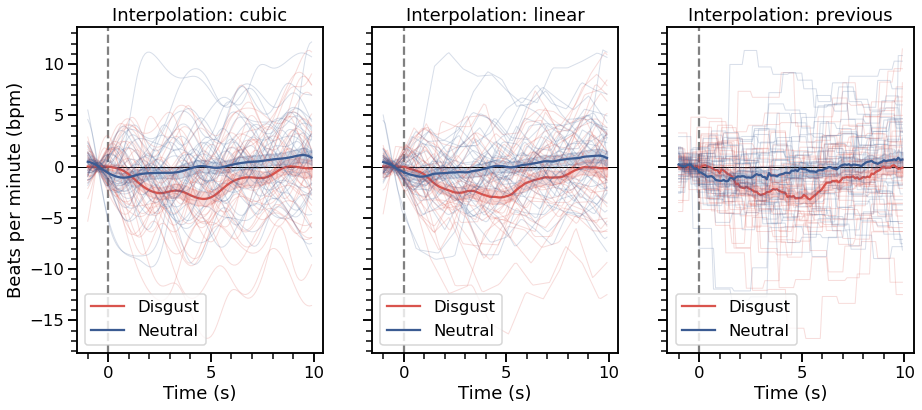

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

for i, kind in enumerate(["cubic", "linear", "previous"]):
    axs[i].set_title(f"Interpolation: {kind}")
    plot_evoked(
        rr=peaks, triggers_idx=triggers_idx, input_type="peaks", kind=kind,
        palette=[sns.xkcd_rgb["pale red"], sns.xkcd_rgb["denim blue"]], labels=["Disgust", "Neutral"],
        decim=100, apply_baseline=(-1.0, 0.0), figsize=(6, 6), ax=axs[i], ci=68
    )

# References
**[1]** Legrand, N., Etard, O., Vandevelde, A., Pierre, M., Viader, F., Clochon, P., Doidy, F., Peschanski, D., Eustache, F., & Gagnepain, P. (2020). Long-term modulation of cardiac activity induced by inhibitory control over emotional memories. *Scientific Reports, 10(1)*. https://doi.org/10.1038/s41598-020-71858-2 